## Spark session initialisation


In [291]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName('heart_failure') \
    .getOrCreate()
    
spark

In [292]:
from platform import python_version

print(python_version())

3.10.6


#### Import libraries

In [294]:
from chart_studio.plotly import plot, iplot
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from colorama import Fore, Back, Style 
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

## Data loading

In [295]:
hearts  = spark.read.csv("heart_failure_clinical_records_dataset.csv", \
                                        header=True, inferSchema=True)

#### About the data:

age: Age of the patient\
anaemia: If the patient had the haemoglobin below the normal range 0 = No, 1 = Yes\
creatinine_phosphokinase: The level of the creatine phosphokinase in the blood in mcg/L\
diabetes: If the patient was diabetic 0 = No, 1 = Yes\
ejection_fraction: Ejection fraction is a measurement of how much blood the left ventricle pumps out with each contraction (connected with heart)\
high_blood_pressure: If the patient had hypertension 0 = No, 1 = Yes\
platelets: Platelet count of blood in kiloplatelets/mL\
serum_creatinine: The level of serum creatinine in the blood in mg/dL\
serum_sodium: The level of serum sodium in the blood in mEq/L\
sex: The sex of the patient Male = 1, Female =0\
smoking: If the patient smokes actively or ever did in past 0 = No, 1 = Yes\
time: It is the time of the patient's follow-up visit for the disease in months\
DEATH_EVENT: If the patient deceased during the follow-up period 0 = No, 1 = Yes

## Data Preprocessing 

In [296]:
hearts.rdd.getNumPartitions()

1

In [297]:
hearts.show()

+----+-------+------------------------+--------+-----------------+-------------------+---------+----------------+------------+---+-------+----+-----------+
| age|anaemia|creatinine_phosphokinase|diabetes|ejection_fraction|high_blood_pressure|platelets|serum_creatinine|serum_sodium|sex|smoking|time|DEATH_EVENT|
+----+-------+------------------------+--------+-----------------+-------------------+---------+----------------+------------+---+-------+----+-----------+
|75.0|      0|                     582|       0|               20|                  1| 265000.0|             1.9|         130|  1|      0|   4|          1|
|55.0|      0|                    7861|       0|               38|                  0|263358.03|             1.1|         136|  1|      0|   6|          1|
|65.0|      0|                     146|       0|               20|                  0| 162000.0|             1.3|         129|  1|      1|   7|          1|
|50.0|      1|                     111|       0|               2

#### Save as parquet

In [298]:
#hearts.write.parquet("hearts.parquet")

#### Load parquet

In [299]:
df = spark.read.parquet("hearts.parquet")

#### Repartition the data (5 partitions)

In [300]:
df = df.repartition(5).cache()

In [301]:
df.rdd.getNumPartitions()

5

#### How data look like?

In [302]:
df.printSchema()

root
 |-- age: double (nullable = true)
 |-- anaemia: integer (nullable = true)
 |-- creatinine_phosphokinase: integer (nullable = true)
 |-- diabetes: integer (nullable = true)
 |-- ejection_fraction: integer (nullable = true)
 |-- high_blood_pressure: integer (nullable = true)
 |-- platelets: double (nullable = true)
 |-- serum_creatinine: double (nullable = true)
 |-- serum_sodium: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- smoking: integer (nullable = true)
 |-- time: integer (nullable = true)
 |-- DEATH_EVENT: integer (nullable = true)



#### How many null cells we have?

In [303]:
df.toPandas().isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

No null values in any columns

In [304]:
df.show()

+------+-------+------------------------+--------+-----------------+-------------------+---------+----------------+------------+---+-------+----+-----------+
|   age|anaemia|creatinine_phosphokinase|diabetes|ejection_fraction|high_blood_pressure|platelets|serum_creatinine|serum_sodium|sex|smoking|time|DEATH_EVENT|
+------+-------+------------------------+--------+-----------------+-------------------+---------+----------------+------------+---+-------+----+-----------+
|  58.0|      0|                     582|       1|               35|                  0| 122000.0|             0.9|         139|  1|      1|  71|          0|
|  72.0|      1|                     110|       0|               25|                  0| 274000.0|             1.0|         140|  1|      1|  65|          1|
|  55.0|      0|                    1820|       0|               38|                  0| 270000.0|             1.2|         139|  0|      0| 271|          0|
|  70.0|      1|                     171|       0|  

#### Summary statistics of our data 

In [305]:
df.describe().toPandas()

,summary,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,count,299,299,299,299,299,299,299,299,299,299,299,299,299
1,mean,60.83389297658862,0.431438127090301,581.8394648829432,0.4180602006688963,38.08361204013378,0.3511705685618729,263358.02926421404,1.3938795986622075,136.62541806020067,0.6488294314381271,0.3210702341137124,130.2608695652174,0.3210702341137124
2,stddev,11.894809074044469,0.49610726813307926,970.287880712436,0.494067065103609,11.834840741039171,0.47813637906274464,97804.2368685983,1.0345100640898541,4.4124772839092365,0.47813637906274464,0.46767042805677167,77.61420795029339,0.4676704280567716
3,min,40.0,0,23,0,14,0,25100.0,0.5,113,0,0,4,0
4,max,95.0,1,7861,1,80,1,850000.0,9.4,148,1,1,285,1


In [306]:
df.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int32  
 2   creatinine_phosphokinase  299 non-null    int32  
 3   diabetes                  299 non-null    int32  
 4   ejection_fraction         299 non-null    int32  
 5   high_blood_pressure       299 non-null    int32  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int32  
 9   sex                       299 non-null    int32  
 10  smoking                   299 non-null    int32  
 11  time                      299 non-null    int32  
 12  DEATH_EVENT               299 non-null    int32  
dtypes: float64(3), int32(10)
memory usage: 18.8 KB


#### Correlation Heatmap

We need to check relations between features

<AxesSubplot: >

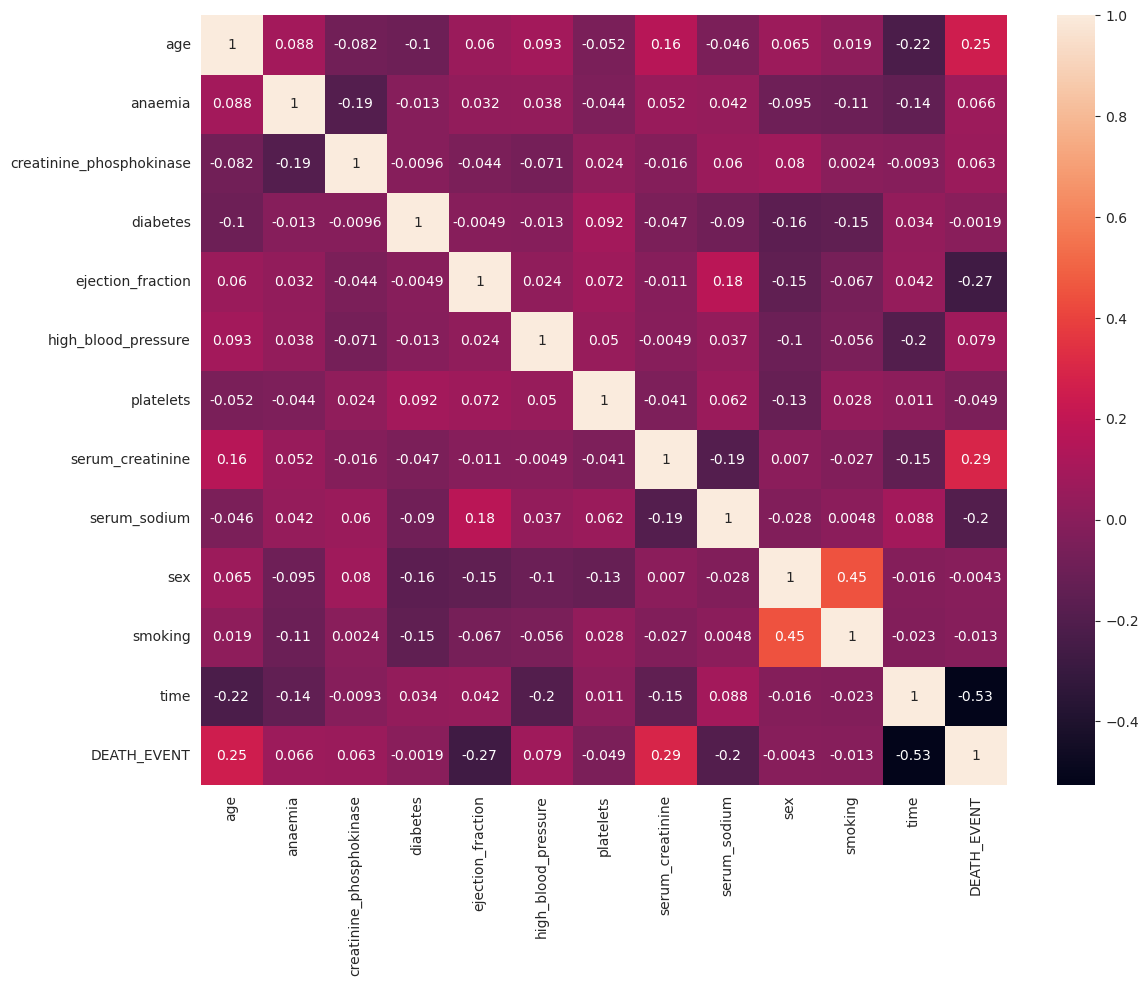

In [307]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df.columns, outputCol=vector_col)
df_vector = assembler.transform(df).select(vector_col)
matrix = Correlation.corr(df_vector, vector_col)
corr_matrix = matrix.collect()[0][matrix.columns[0]].toArray()
corr_matrix_df = pd.DataFrame(data=corr_matrix) 
plt.figure(figsize=(13,10))
sns.heatmap(df.toPandas().corr(method='pearson'), annot=True)

We can see that none of the features are highly correlated (>0.7)\
The most correlated feature is time (moderatly corr.), but negative.
The rest are low correlated.\
To predict death event we will use following features:
 - Time (moderatly corr.), the most correlated feature but negative
 - Ejection fraction (describes efficiency of the heart), also negative
 - Serum creatinine

#### Death event - histogram

We need to examine if our data are balanced or not

In [308]:
df.createOrReplaceTempView('de')

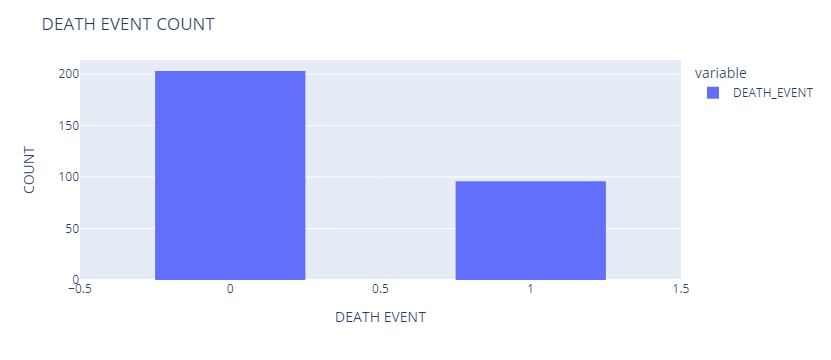

In [309]:
fig = px.histogram(df.select("DEATH_EVENT").toPandas())
fig.update_layout(
    title_text='DEATH EVENT COUNT',
    xaxis_title_text='DEATH EVENT',
    yaxis_title_text='COUNT', 
    bargap=0.5, 
)
fig.show()

Our target variable is imbalanced, so we need to treat it before applying any model

## Analysis before applying model

#### Time

Finding outliers in time

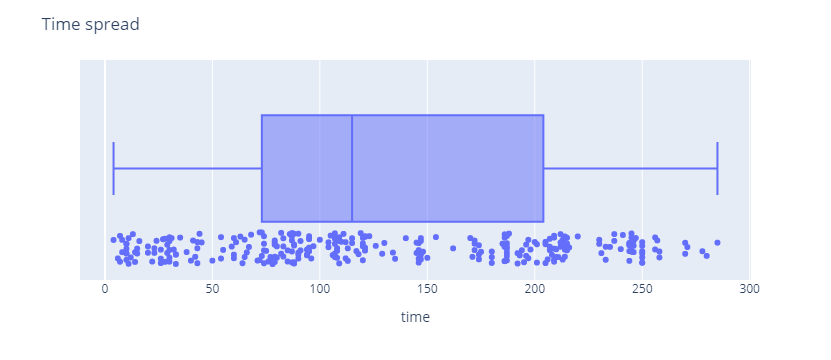

In [310]:
# Boxplot for time
fig = px.box(df.toPandas(), x='time', points="all")
fig.update_layout(
    title_text="Time spread")
fig.show()

There are no outliers in time.

#### Ejection fraction

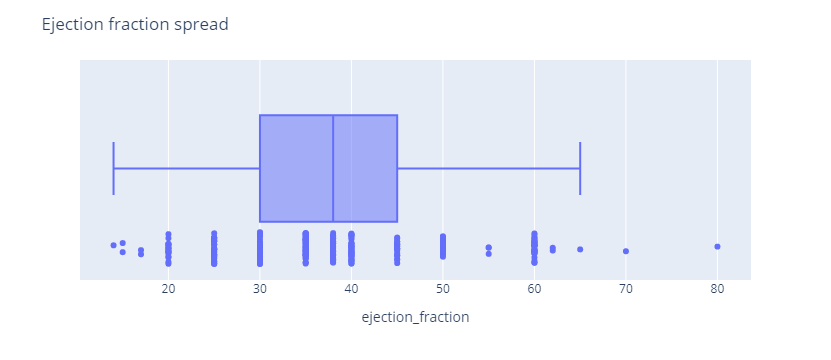

In [311]:
# Boxplot for ejection_fraction
fig = px.box(df.toPandas(), x='ejection_fraction', points="all")
fig.update_layout(
    title_text="Ejection fraction spread")
fig.show()

We can see two outliers (70 and 80), so we need to get rid of it


In [312]:
df = df[df['ejection_fraction']<70]

#### Serum creatinine

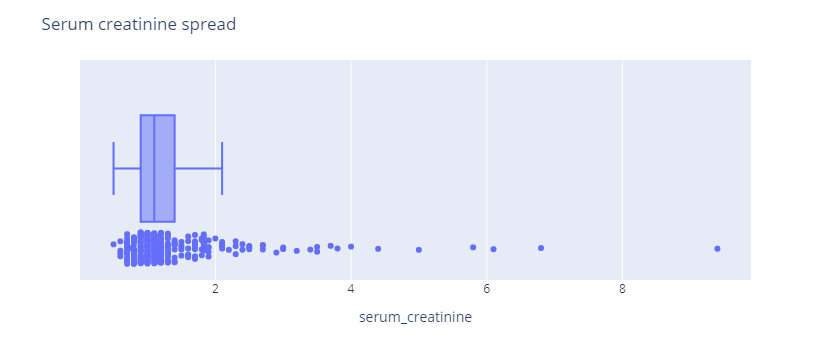

In [313]:
# Boxplot for serum_creatinine
fig = px.box(df.toPandas(), x='serum_creatinine', points="all")
fig.update_layout(
    title_text="Serum creatinine spread")
fig.show()

We have a lot of outliers here, so it is kind od suspicious, but in this case we need to leave this as it is, bc we need this data for better predictions od death event (this high level of serum creatinine is medically possible)

### Research questions:

#### 1.	Is age and sex an indicator for death event?

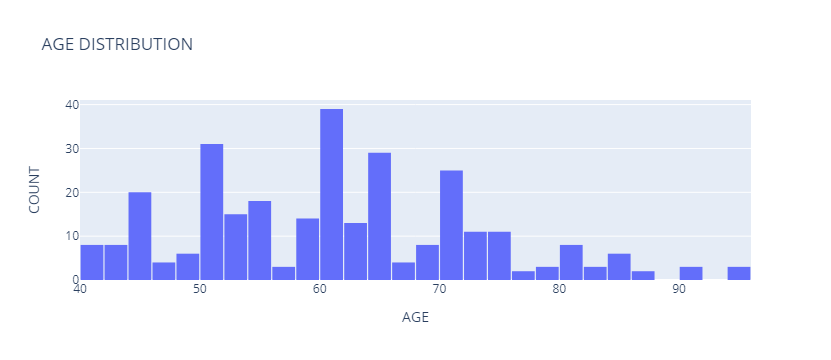

In [314]:
fig = go.Figure()
fig.add_trace(go.Histogram(
    x = df.toPandas()['age'],
    xbins=dict( 
        start=40,
        end=95,
        size=2
    ),
))

fig.update_layout(
    title_text='AGE DISTRIBUTION',
    xaxis_title_text='AGE',
    yaxis_title_text='COUNT', 
    bargap=0.05, 
)
fig.show()

We don't have any people under 40 and above 95 years.
Age higher than 80 are very low.

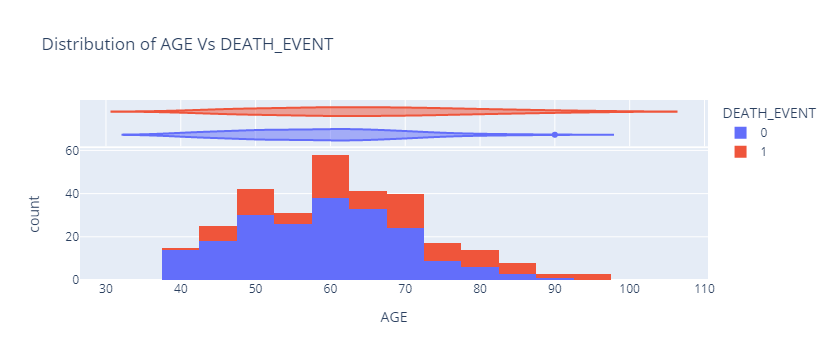

In [315]:
fig = px.histogram(df.toPandas(), x="age", color="DEATH_EVENT", marginal="violin", hover_data=df.columns, 
                   title ="Distribution of AGE Vs DEATH_EVENT", 
                   labels={"age": "AGE"},
                  )
fig.show()

Survival is high on 40-70.


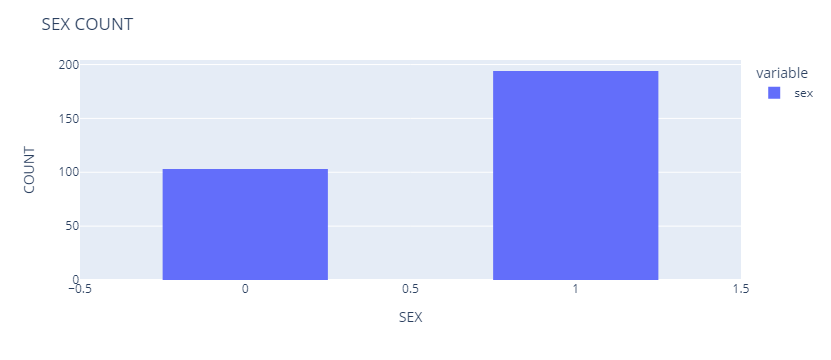

In [316]:
fig = px.histogram(df.select("sex").toPandas())
fig.update_layout(
    title_text='SEX COUNT',
    xaxis_title_text='SEX',
    yaxis_title_text='COUNT', 
    bargap=0.5, 
)
fig.show()

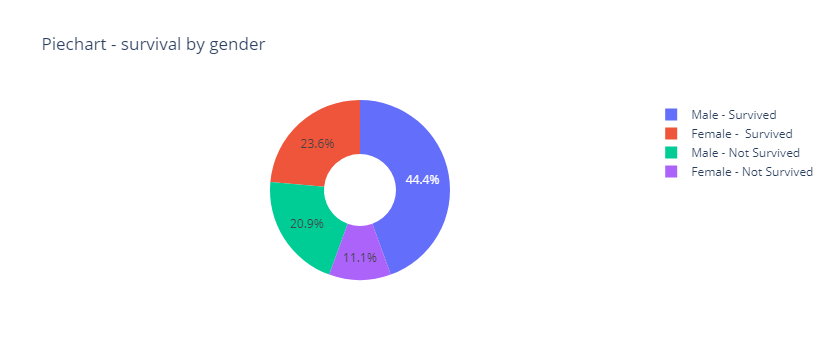

In [317]:
#!df delect
male = df[df["sex"]==1]
female = df[df["sex"]==0]

male_surv = male[df["DEATH_EVENT"]==0]
male_not = male[df["DEATH_EVENT"]==1]
female_surv = female[df["DEATH_EVENT"]==0]
female_not = female[df["DEATH_EVENT"]==1]

labels = ['Male - Survived','Male - Not Survived', "Female -  Survived", "Female - Not Survived"]
values = [male_surv.count(),male_not.count(), female_surv.count(), female_not.count()]
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.4)])
fig.update_layout(
    title_text="Piechart - survival by gender")
fig.show()

Survival (by percent):\
Female 71/105 = 67,6 %\
Male 132/194 = 68,0 %

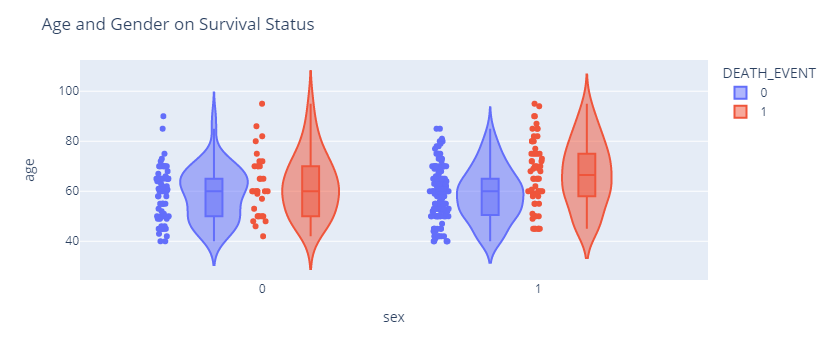

In [318]:
fig = px.violin(df.toPandas(), y="age", x="sex", color="DEATH_EVENT", box=True, points="all", hover_data=df.columns)
fig.update_layout(title_text="Age and Gender on Survival Status")
fig.show()

The Survival is the highest for male between 50 to 60 and female's between 60 to 70.

#### 2.	How many smoking persons survived?

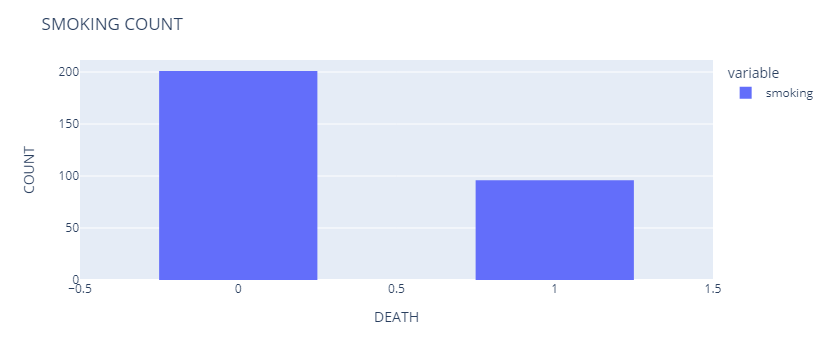

In [319]:
fig = px.histogram(df.select("smoking").toPandas())

fig.update_layout(
    title_text='SMOKING COUNT',
    xaxis_title_text='DEATH',
    yaxis_title_text='COUNT', 
    bargap=0.5,
)
fig.show()

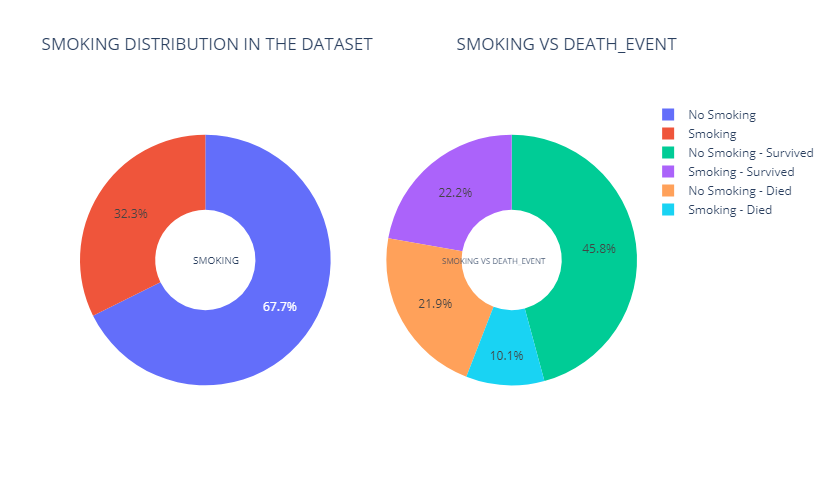

In [320]:
d1 = df.toPandas()[(df.toPandas()["DEATH_EVENT"]==0) & (df.toPandas()["smoking"]==0)]
d2 = df.toPandas()[(df.toPandas()["DEATH_EVENT"]==1) & (df.toPandas()["smoking"]==0)]
d3 = df.toPandas()[(df.toPandas()["DEATH_EVENT"]==0) & (df.toPandas()["smoking"]==1)]
d4 = df.toPandas()[(df.toPandas()["DEATH_EVENT"]==1) & (df.toPandas()["smoking"]==1)]

label1 = ["No Smoking","Smoking"]
label2 = ['No Smoking - Survived','No Smoking - Died', "Smoking - Survived", "Smoking - Died"]
values1 = [(len(d1)+len(d2)), (len(d3)+len(d4))]
values2 = [len(d1),len(d2),len(d3),len(d4)]

fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=label1, values=values1, name="SMOKING"),
              1, 1)
fig.add_trace(go.Pie(labels=label2, values=values2, name="SMOKING VS DEATH_EVENT"),
              1, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="value+label+percent")

fig.update_layout(
    title_text="SMOKING DISTRIBUTION IN THE DATASET \
                  SMOKING VS DEATH_EVENT",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='SMOKING', x=0.20, y=0.5, font_size=10, showarrow=False),
                 dict(text='SMOKING VS DEATH_EVENT', x=0.84, y=0.5, font_size=8, showarrow=False)],
    autosize=False,width=1200, height=500, paper_bgcolor="white")
fig.show()

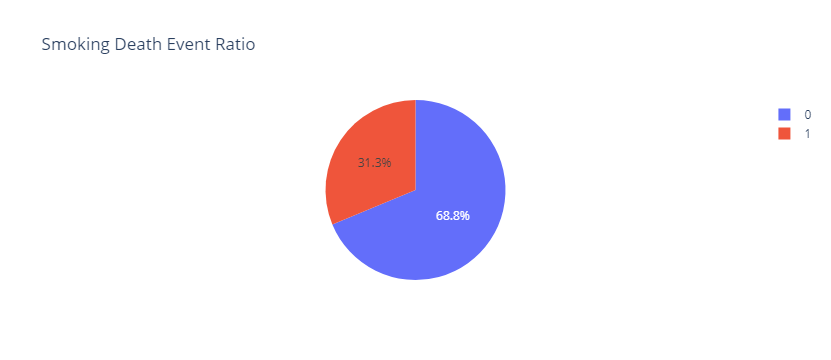

In [321]:
fig = px.pie(df.toPandas(), values='smoking',names='DEATH_EVENT', title='Smoking Death Event Ratio')
fig.show()

We can observe that in our dataset from 96 smoking persons 66 survived (30 not), so is giving us a survival rate of 68,75% smoking persons.

#### 3.	Has the smoking an influence on the ejection fraction?

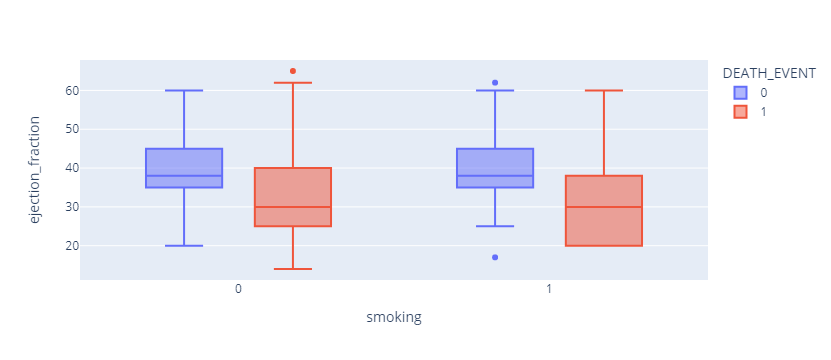

In [322]:
fig = px.box(df.toPandas(), x='smoking', y="ejection_fraction",color = 'DEATH_EVENT')
fig.show()

Smoking causes slight decrease in ejection fraction

## Data models

In [360]:
from pyspark.ml import Pipeline
import pyspark.sql.functions as F


In [361]:
# Features used to predict death event
Features = ['time','ejection_fraction','serum_creatinine', 'DEATH_EVENT']
x = df.select(Features)
cols = x.columns
x.show(10)
x.printSchema()

+----+-----------------+----------------+-----------+
|time|ejection_fraction|serum_creatinine|DEATH_EVENT|
+----+-----------------+----------------+-----------+
|  71|               35|             0.9|          0|
|  65|               25|             1.0|          1|
| 271|               38|             1.2|          0|
| 146|               60|             1.1|          0|
| 120|               35|             1.4|          0|
| 113|               30|            1.83|          1|
| 250|               38|             1.1|          0|
|  75|               40|             1.7|          0|
| 112|               30|             0.7|          0|
|  12|               30|             1.0|          0|
+----+-----------------+----------------+-----------+
only showing top 10 rows

root
 |-- time: integer (nullable = true)
 |-- ejection_fraction: integer (nullable = true)
 |-- serum_creatinine: double (nullable = true)
 |-- DEATH_EVENT: integer (nullable = true)



In [362]:
x.dtypes

[('time', 'int'),
 ('ejection_fraction', 'int'),
 ('serum_creatinine', 'double'),
 ('DEATH_EVENT', 'int')]

In [363]:
numCols = [ i for (i, dataType) in x.dtypes if ((dataType == "double") | (dataType == "int") & (i != 'DEATH_EVENT'))
          ]
print(numCols)

['time', 'ejection_fraction', 'serum_creatinine']


We don't have categorical data, no need for string indexer and one hot encoding

In [364]:
#Vector assembling
assemblerInput = [i for i in numCols]
assemblerInput
vector_assembler = VectorAssembler(
  inputCols = assemblerInput, outputCol="VectorAssembler_features"   
)

In [365]:
#creating stages for pipeline -chain between transformers and estimators
stages = []
stages += [vector_assembler]
stages

[VectorAssembler_449d9ae7416e]

In [366]:
#Building pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(x)
df = pipelineModel.transform(x)
selectedCols = ['VectorAssembler_features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- VectorAssembler_features: vector (nullable = true)
 |-- time: integer (nullable = true)
 |-- ejection_fraction: integer (nullable = true)
 |-- serum_creatinine: double (nullable = true)
 |-- DEATH_EVENT: integer (nullable = true)



In [367]:
# Split the dataset into training set and test set
train, test= df.randomSplit([0.8, 0.2])

In [368]:
print(f"train set length: {train.count()} records")
print(f"test set length: {test.count()} records")

train set length: 231 records
test set length: 66 records


In [369]:
# Initializing accuracy list, used in summary
accuracy_list = []

#### Logistic regression

In [370]:
from pyspark.ml.classification import LogisticRegression

In [371]:
log_reg = LogisticRegression(featuresCol = 'VectorAssembler_features', labelCol = 'DEATH_EVENT', maxIter=10)
log_reg_model = log_reg.fit(train)

In [372]:
predictions = log_reg_model.transform(test)
predictions.select('time','ejection_fraction','serum_creatinine', 'prediction', 'DEATH_EVENT').show(10)

+----+-----------------+----------------+----------+-----------+
|time|ejection_fraction|serum_creatinine|prediction|DEATH_EVENT|
+----+-----------------+----------------+----------+-----------+
|   8|               40|             2.1|       1.0|          1|
|  30|               35|             3.5|       1.0|          1|
|  71|               35|             0.9|       0.0|          0|
| 107|               40|            1.18|       0.0|          0|
| 113|               30|            1.83|       0.0|          1|
| 115|               45|             2.5|       0.0|          1|
| 135|               20|             2.4|       1.0|          1|
| 174|               35|             2.1|       0.0|          0|
| 174|               60|             1.5|       0.0|          0|
| 250|               40|             2.7|       0.0|          0|
+----+-----------------+----------------+----------+-----------+
only showing top 10 rows



In [373]:
evaluator = BinaryClassificationEvaluator(labelCol="DEATH_EVENT")
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8528015194681862


In [374]:
print("Accuracy of Logistic Regression is : ", "{:.2f}%".format(100* evaluator.evaluate(predictions)))
accuracy_list.append(100*evaluator.evaluate(predictions))

Accuracy of Logistic Regression is :  85.28%


<Figure size 2000x800 with 0 Axes>

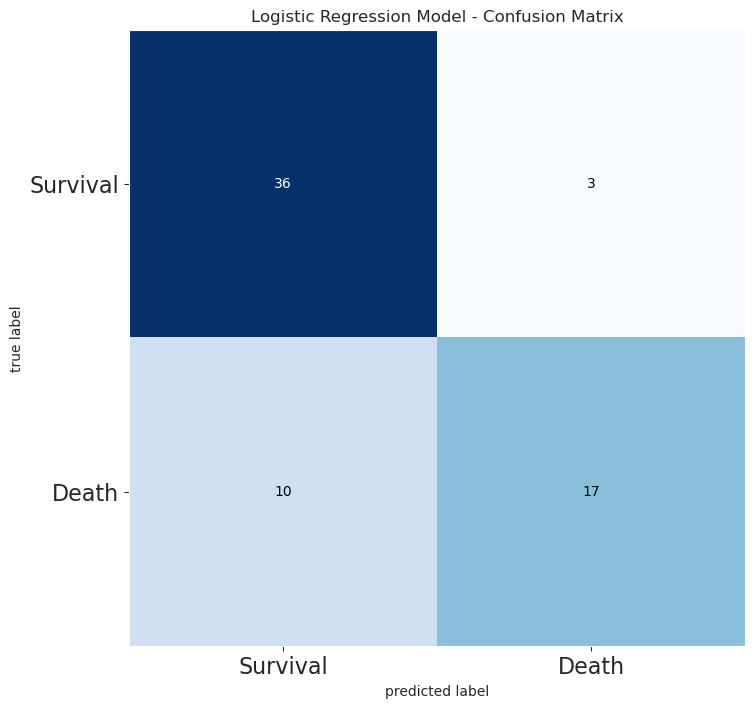

In [375]:
from sklearn.metrics import confusion_matrix
y_true = predictions.select("DEATH_EVENT")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cm = confusion_matrix(y_true, y_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("Logistic Regression Model - Confusion Matrix")
plt.xticks(range(2), ["Survival","Death"], fontsize=16)
plt.yticks(range(2), ["Survival","Death"], fontsize=16)
plt.show()

#### Random Forest Classifier

In [376]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'VectorAssembler_features', labelCol = 'DEATH_EVENT', numTrees=10)
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('time', 'ejection_fraction', 'serum_creatinine', 'prediction', 'DEATH_EVENT').show(10)

+----+-----------------+----------------+----------+-----------+
|time|ejection_fraction|serum_creatinine|prediction|DEATH_EVENT|
+----+-----------------+----------------+----------+-----------+
|   8|               40|             2.1|       1.0|          1|
|  30|               35|             3.5|       1.0|          1|
|  71|               35|             0.9|       1.0|          0|
| 107|               40|            1.18|       0.0|          0|
| 113|               30|            1.83|       0.0|          1|
| 115|               45|             2.5|       0.0|          1|
| 135|               20|             2.4|       1.0|          1|
| 174|               35|             2.1|       0.0|          0|
| 174|               60|             1.5|       0.0|          0|
| 250|               40|             2.7|       0.0|          0|
+----+-----------------+----------------+----------+-----------+
only showing top 10 rows



In [377]:
evaluator = BinaryClassificationEvaluator(labelCol="DEATH_EVENT")
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8300094966761632


In [378]:
print("Accuracy of Random Forest Classifier is : ", "{:.2f}%".format(100* evaluator.evaluate(predictions)))
accuracy_list.append(100*evaluator.evaluate(predictions))

Accuracy of Random Forest Classifier is :  83.00%


<Figure size 2000x800 with 0 Axes>

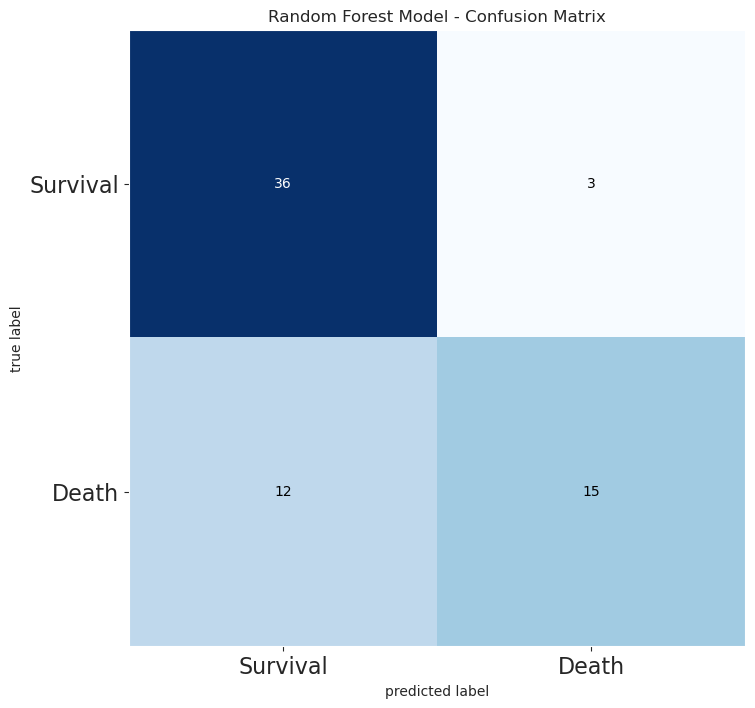

In [379]:
y_true = predictions.select("DEATH_EVENT")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cm = confusion_matrix(y_true, y_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("Random Forest Model - Confusion Matrix")
plt.xticks(range(2), ["Survival","Death"], fontsize=16)
plt.yticks(range(2), ["Survival","Death"], fontsize=16)
plt.show()

#### DecisionTreeClassifier

In [380]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'VectorAssembler_features', labelCol = 'DEATH_EVENT', maxDepth = 10)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('time', 'ejection_fraction', 'serum_creatinine', 'prediction', 'DEATH_EVENT').show(10)

+----+-----------------+----------------+----------+-----------+
|time|ejection_fraction|serum_creatinine|prediction|DEATH_EVENT|
+----+-----------------+----------------+----------+-----------+
|   8|               40|             2.1|       1.0|          1|
|  30|               35|             3.5|       1.0|          1|
|  71|               35|             0.9|       1.0|          0|
| 107|               40|            1.18|       0.0|          0|
| 113|               30|            1.83|       1.0|          1|
| 115|               45|             2.5|       0.0|          1|
| 135|               20|             2.4|       1.0|          1|
| 174|               35|             2.1|       0.0|          0|
| 174|               60|             1.5|       0.0|          0|
| 250|               40|             2.7|       0.0|          0|
+----+-----------------+----------------+----------+-----------+
only showing top 10 rows



In [381]:
evaluator = BinaryClassificationEvaluator(labelCol="DEATH_EVENT")
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7459639126305793


In [382]:
print("Accuracy of Decision Tree Classifier is : ", "{:.2f}%".format(100* evaluator.evaluate(predictions)))
accuracy_list.append(100*evaluator.evaluate(predictions))

Accuracy of Decision Tree Classifier is :  74.60%


<Figure size 2000x800 with 0 Axes>

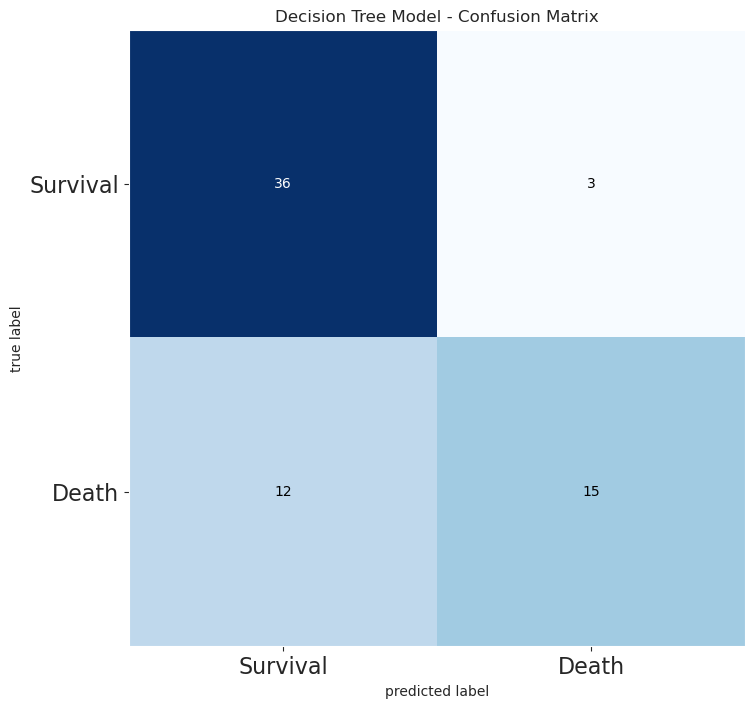

In [383]:
y_true = predictions.select("DEATH_EVENT")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cm = confusion_matrix(y_true, y_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("Decision Tree Model - Confusion Matrix")
plt.xticks(range(2), ["Survival","Death"], fontsize=16)
plt.yticks(range(2), ["Survival","Death"], fontsize=16)
plt.show()

#### Gradient Boosted Tree Classifier

In [384]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(featuresCol = 'VectorAssembler_features', labelCol = 'DEATH_EVENT', maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('time', 'ejection_fraction', 'serum_creatinine', 'prediction', 'DEATH_EVENT').show(10)

+----+-----------------+----------------+----------+-----------+
|time|ejection_fraction|serum_creatinine|prediction|DEATH_EVENT|
+----+-----------------+----------------+----------+-----------+
|   8|               40|             2.1|       1.0|          1|
|  30|               35|             3.5|       1.0|          1|
|  71|               35|             0.9|       1.0|          0|
| 107|               40|            1.18|       0.0|          0|
| 113|               30|            1.83|       1.0|          1|
| 115|               45|             2.5|       0.0|          1|
| 135|               20|             2.4|       1.0|          1|
| 174|               35|             2.1|       1.0|          0|
| 174|               60|             1.5|       0.0|          0|
| 250|               40|             2.7|       0.0|          0|
+----+-----------------+----------------+----------+-----------+
only showing top 10 rows



In [385]:
evaluator = BinaryClassificationEvaluator(labelCol="DEATH_EVENT")
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.855650522317189


In [386]:
print("Accuracy of Decision Tree Classifier is : ", "{:.2f}%".format(100* evaluator.evaluate(predictions)))
accuracy_list.append(100*evaluator.evaluate(predictions))

Accuracy of Decision Tree Classifier is :  85.57%


<Figure size 2000x800 with 0 Axes>

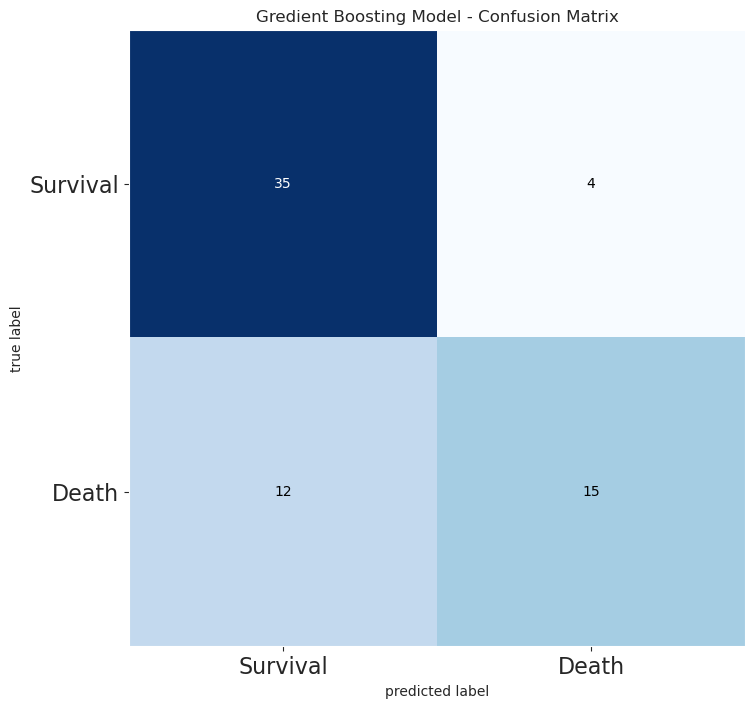

In [387]:
y_true = predictions.select("DEATH_EVENT")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cm = confusion_matrix(y_true, y_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("Gredient Boosting Model - Confusion Matrix")
plt.xticks(range(2), ["Survival","Death"], fontsize=16)
plt.yticks(range(2), ["Survival","Death"], fontsize=16)
plt.show()

Gradient-Boosted Tree achieved the best result

#### Gradient Boosted Tree Classifier - Param_builder

In [388]:
#print(gbt.explainParams())

In [389]:
#tuning GBT with ParamGridBuilder and CrossValidator, takes some time
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

0.8566001899335232

In [390]:
print("Accuracy of Decision Tree Classifier is : ", "{:.2f}%".format(100* evaluator.evaluate(predictions)))
accuracy_list.append(100*evaluator.evaluate(predictions))

Accuracy of Decision Tree Classifier is :  85.66%


<Figure size 2000x800 with 0 Axes>

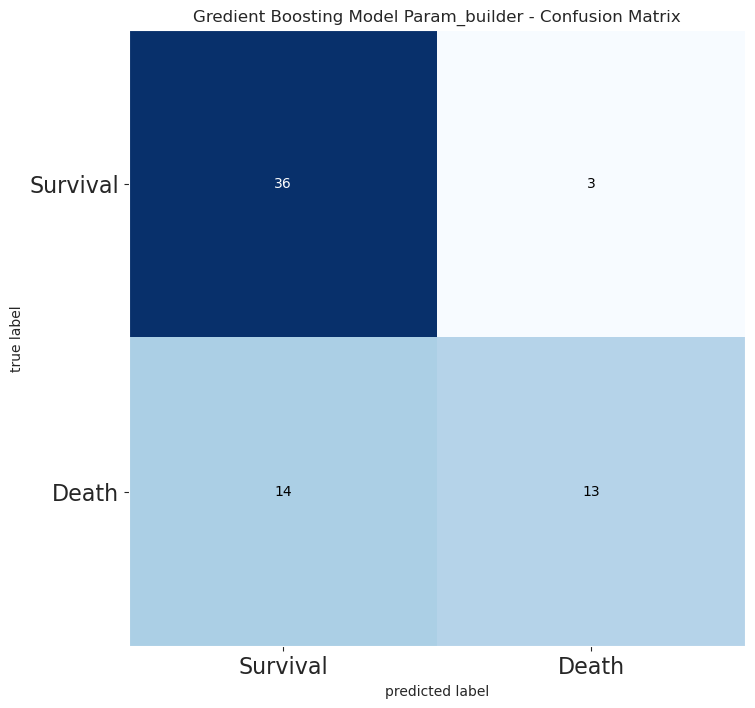

In [391]:
y_true = predictions.select("DEATH_EVENT")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cm = confusion_matrix(y_true, y_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("Gredient Boosting Model Param_builder - Confusion Matrix")
plt.xticks(range(2), ["Survival","Death"], fontsize=16)
plt.yticks(range(2), ["Survival","Death"], fontsize=16)
plt.show()

#### Summary

In [392]:
model_list = [ 'Logistic Regression', 'RandomForest', 'DecisionTree',
              'GradientBooster','GradientBooster - param_builder' ]

In [393]:
#accuracy_list = []

In [394]:
print(accuracy_list)

[85.28015194681862, 83.00094966761633, 74.59639126305792, 85.5650522317189, 85.66001899335231]


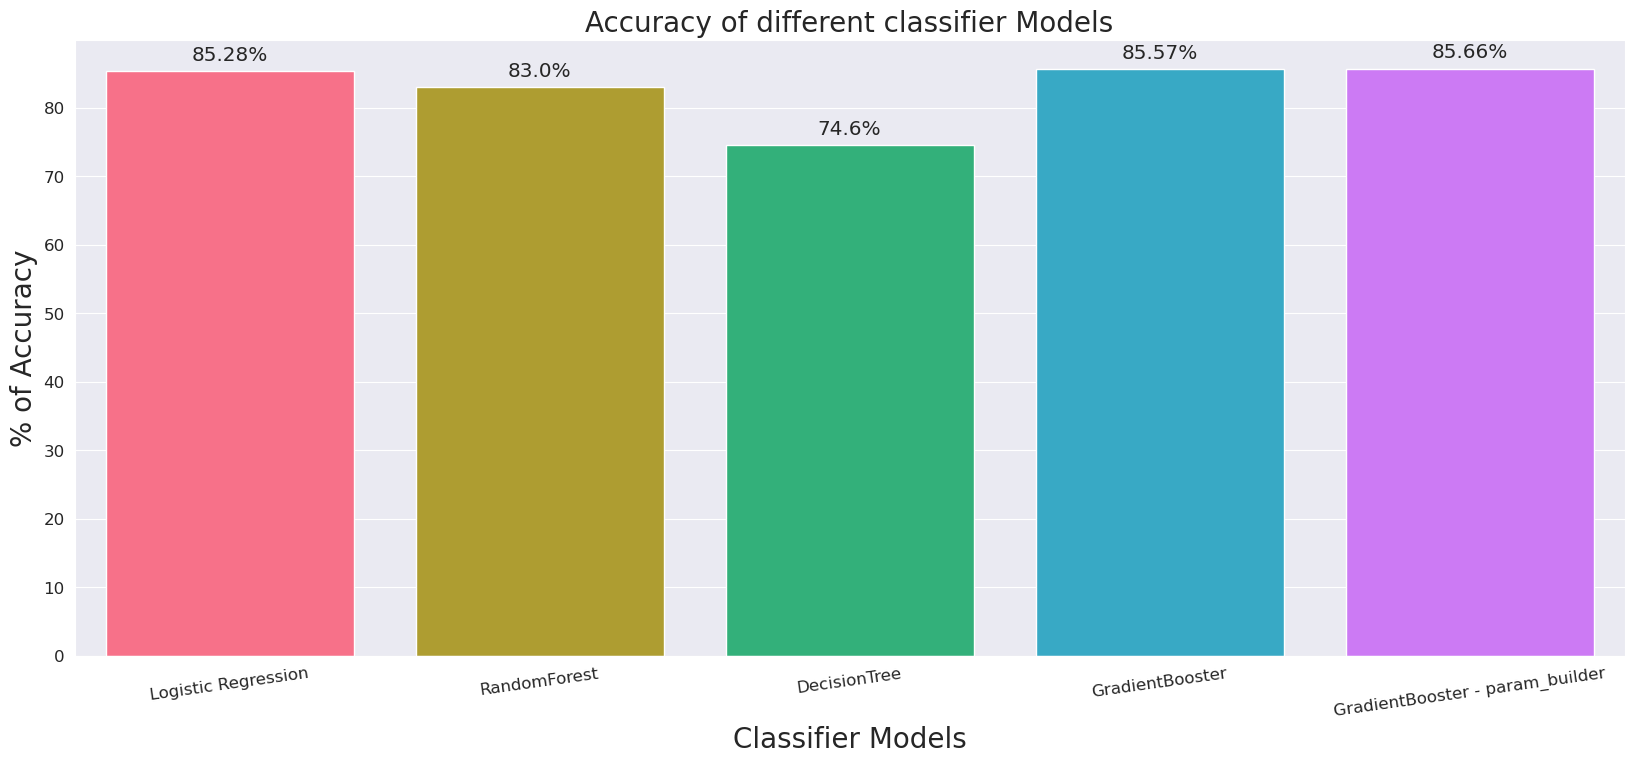

In [395]:
plt.rcParams['figure.figsize']=20,8
sns.set_style('darkgrid')
ax = sns.barplot(x=model_list, y=accuracy_list, palette = "husl", saturation =2.0)
plt.xlabel('Classifier Models', fontsize = 20 )
plt.ylabel('% of Accuracy', fontsize = 20)
plt.title('Accuracy of different classifier Models', fontsize = 20)
plt.xticks(fontsize = 12, horizontalalignment = 'center', rotation = 8)
plt.yticks(fontsize = 12)
for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy() 
    ax.annotate(f'{round(height,2)}%', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')
plt.show()

Summary:
The best accuracy was achieved with Gradient Booster classifier, but during experiments sometimes even higher accuracies wad achieved for Logistic Regression also. But overall Gradient Booster and Logistic Regression had the highest accuracies.
